In [1]:
import importlib
from ipykernel import get_connection_file
from IPython.display import clear_output
import json
import logging
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import os
import pandas as pd
import porespy as ps
import pickle
from PIL import Image, ImageOps
from scipy.fft import fft, fftfreq
from sklearn.manifold import TSNE
import sklearn.metrics
import sys
import torch
import torch.nn as nn

from base_functions import get_local_folder

current = get_local_folder()
parent = os.path.dirname(current)
sys.path.append(parent)
sys.path.append(os.path.join(parent, "models"))

from data.dataset import EyeDataset
from features.build_features import feature_extraction

C:\Users\aneta.kartali\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


[14:43:51] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=320398;file://C:\Users\aneta.kartali\AppData\Local\anaconda3\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=774869;file://C:\Users\aneta.kartali\AppData\Local\anaconda3\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
model_architecture = "protoeyetcn"

# Load modules and params
module = importlib.import_module(f'models.model.{model_architecture}')
Model = module.Model
params = importlib.import_module(f'models.model.params.{model_architecture}_params')

model_params = params.model_params
data_params = params.data_params
log_params = params.log_params
train_params = params.train_params

In [4]:
model_params.data_info = True
data_params.data_info = True
Fs = params.Fs
time_context = params.time_context
dataset = params.dataset

## Loading the trained model

In [5]:
log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format=log_fmt)

logger = logging.getLogger(__name__)
logger.info(f'Evaluating model {model_architecture}')

In [6]:
# Create loss function
if model_params.criterion == 'BCE':
    criterion = nn.BCELoss()
elif model_params.criterion == 'BCE_with_logits':
    criterion = nn.BCEWithLogitsLoss()
elif model_params.criterion == 'CE':
    criterion = nn.CrossEntropyLoss()
else:
    logger.info(f"ERROR: Unsupported loss function: {model_params.criterion}")
    sys.exit()

regularizer = None

In [7]:
# Instantiate and initiate the model
if 'proto' in model_architecture:
    stage = -1
    model = Model(train_params.device, model_params, criterion, regularizer, stage, logger)
else:
    model = Model(train_params.device, model_params, criterion, regularizer, logger) 
    
logger.info("\n")
logger.info("Model architecture:")
logger.info(model.encoder)
if 'proto' in model_architecture:
    logger.info(model.prototype_layer)
logger.info(model.decoder)
logger.info("\n")

total_params, trainable_params = model.get_parameter_count()
logger.info(f"Total number of model parameters: {total_params}")
logger.info(f"Number of trainable model parameters: {trainable_params}")
logger.info("\n")

In [8]:
checkpoint_path = f"../results/Benfatto/6s_segments/{model_architecture}/single_train_test_split/"

if 'proto' in model_architecture:
    checkpoint_path = checkpoint_path + 'stages_2_3_4/'
    checkpoint_name = "checkpoint_200.pt"
    model.load_model(os.path.join(checkpoint_path, checkpoint_name), Model)
else:
    checkpoint_name = "checkpoint_100.pt"
    model.load_model(os.path.join(checkpoint_path, checkpoint_name))

In [9]:
# Use CUDA if available
set_spawn_method = False  # For multiprocessing on GPU training - True when using multiple GPUs
if set_spawn_method:
    torch.multiprocessing.set_start_method('spawn', force=True)
num_GPU = torch.cuda.device_count()  # Get number of GPUs
logger.info(f"Found {num_GPU} GPUs.")
logger.info(f"Let's use {num_GPU} GPUs!")
batch_size = num_GPU * model_params.batch_size_GPU

In [10]:
# Load the data
trainDataset = EyeDataset(data_params, model_params.criterion, 'train')
validDataset = EyeDataset(data_params, model_params.criterion, 'valid')

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, shuffle=True, drop_last=False, batch_size=batch_size, num_workers=data_params.num_workers)
validLoader = torch.utils.data.DataLoader(dataset=validDataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=data_params.num_workers)

## Prototype analysis

In [11]:
data_loader = trainLoader

inputs, info, labels = zip(*[batch for batch in data_loader])
inputs = torch.cat(inputs, dim=0).to(train_params.device)
labels = torch.cat(labels, dim=0).to(train_params.device)

filenames = [item for tpl in info for item in tpl[-1]]

In [12]:
# Get predictions of all train sequences
model.eval()
with torch.no_grad():
    if 'proto' in model_architecture:
        logits, proto_loss = model.forward(inputs, labels)
    else:
        logits = model.forward(inputs, labels)
    predictions = logits
if model_params.criterion == 'BCE_with_logits':
    probabilities = nn.functional.sigmoid(predictions)
elif model_params.criterion == 'CE':
    probabilities = nn.functional.softmax(predictions, dim=1)
if model_params.criterion == 'BCE':
    predictions = (predictions[:,0] > 0.5) * 1.0
elif model_params.criterion == 'BCE_with_logits':
    predictions = (predictions[:,0] > 0.0) * 1.0
elif model_params.criterion == 'CE':
    predictions = torch.argmax(predictions, dim=-1)
targets = labels.squeeze(-1)
matches = (torch.eq(predictions, targets) * 1.0).detach().cpu().numpy().astype(int)

In [13]:
# Get encodings of all train sequences
model.eval()
with torch.no_grad():
    encoded_data = model.encoder.forward(inputs)
    latent = encoded_data['features']  # [batch_size, time_steps, embedding_size]
    if model_params.feature_aggregation == 'pooling':
        latent = torch.mean(latent, dim=1)
    else:
        latent = torch.flatten(latent, start_dim=1)
    latent = torch.unsqueeze(latent, dim=-2)    

In [14]:
# Distance matrix from prototypes
protos = model.prototype_layer.get_weights()
d2 = torch.norm(latent - protos, p=2, dim=-1)

idxs = torch.argmin(d2, dim=0).detach().cpu().numpy()
protos_idxs = idxs
idxs

array([128, 128, 128, 128, 128, 224, 224, 224, 224, 224], dtype=int64)

In [15]:
vals, ids = np.unique(protos_idxs, return_index=True)
ids = np.sort(ids)
unique_idxs = list(protos_idxs[ids])
unique_idxs

[128, 224]

In [16]:
matched_protos = inputs[idxs].detach().cpu().numpy()
matched_labels = labels[idxs].detach().cpu().numpy()
matched_protos.shape

(10, 2, 300)

In [17]:
unique_matched_protos = inputs[unique_idxs].detach().cpu().numpy()
unique_matched_labels = labels[unique_idxs].detach().cpu().numpy()
unique_matched_protos.shape

(2, 2, 300)

In [18]:
filenames_array = np.array([element for tuple in filenames for element in tuple])

In [19]:
prototype_dict = {}
prototype_dict['filenames'] = filenames_array[protos_idxs]
prototype_dict['sequences'] = matched_protos
prototype_dict['labels'] = matched_labels
prototype_dict['unique_filenames'] = filenames_array[unique_idxs]
prototype_dict['unique_sequences'] = unique_matched_protos
prototype_dict['unique_labels'] = unique_matched_labels
prototype_dict['ids_of_unique_protos'] = ids

with open(checkpoint_path + "prototypes.pickle", "wb") as handle:
    pickle.dump(prototype_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Check wich prototype is associated with which class

In [65]:
matches = {}
prototype_labels = []
for i in range(len(protos_idxs)):
    match_ids = np.where(idxs == i)[0]
    class_label = int(unique_matched_labels[unique_idxs.index(protos_idxs[i])])
    prototype_labels.append(class_label)
    matches[str(i)] = []
    for j in range(len(match_ids)):
        if distances[match_ids[j]] < 0.05:
            label_valid = int(labels[match_ids[j]].detach().cpu().numpy())
            matches[str(i)].append(label_valid)

In [66]:
i = 0
for proto in matches:
    print(f"Prototype number {int(proto)+1} is associated with the class {prototype_labels[i]}")
    if len(matches[proto]):
        zero_class_matches = 1-sum(matches[proto])/len(matches[proto])
        print(f"And explains {zero_class_matches} of 0-class validation examples")
    i += 1

Prototype number 1 is associated with the class 0
Prototype number 2 is associated with the class 0
Prototype number 3 is associated with the class 0
Prototype number 4 is associated with the class 0
Prototype number 5 is associated with the class 0
Prototype number 6 is associated with the class 1
Prototype number 7 is associated with the class 1
Prototype number 8 is associated with the class 1
Prototype number 9 is associated with the class 1
Prototype number 10 is associated with the class 1


#### Time domain analysis

In [20]:
FONT_SIZE = 20
class_names = ["HE", "DYS"]

for i in range(unique_matched_protos.shape[0]):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.rc('font', size=FONT_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
    plt.plot(np.arange(unique_matched_protos.shape[-1]), unique_matched_protos[i,0,:], label="x-axis")
    plt.plot(np.arange(unique_matched_protos.shape[-1]), unique_matched_protos[i,1,:], label="y-axis")
    plt.xlabel("Samples")
    plt.ylabel("Relative screen position")
    plt.title(f"Prototype {ids[i]+1} associated with label {class_names[int(unique_matched_labels[i])]}")
    plt.legend()
    plt.savefig(checkpoint_path + f"Prototype_{ids[i]+1}_label_{int(unique_matched_labels[i])}" + ".png", dpi=600, bbox_inches="tight")
    plt.close()
    clear_output(wait=True)

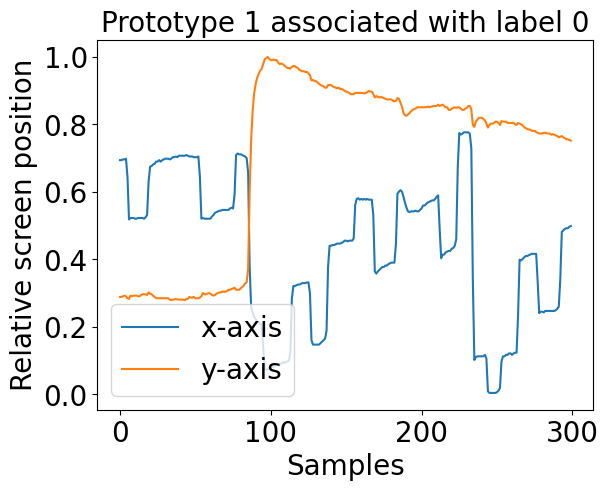

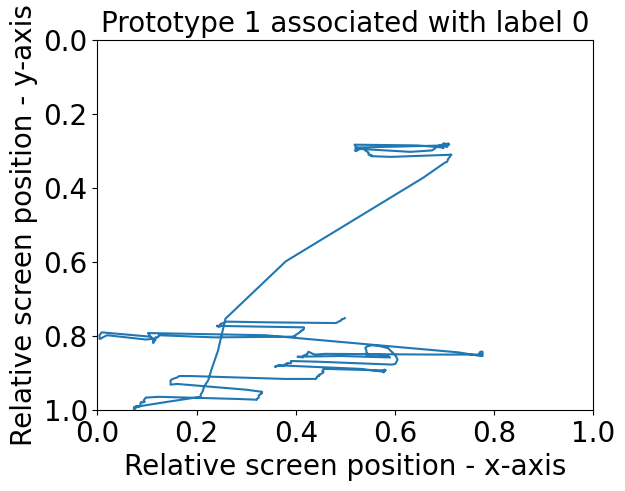

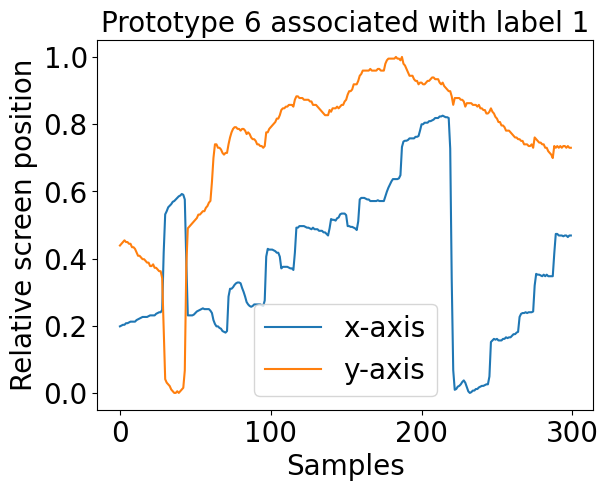

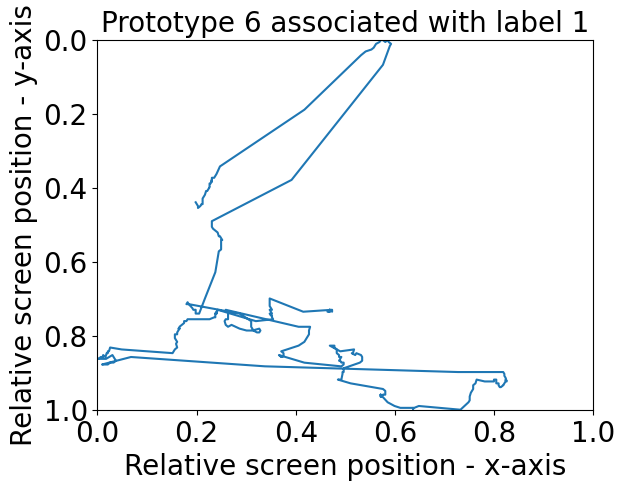

In [21]:
for i in range(unique_matched_protos.shape[0]):
    plt.plot(np.arange(unique_matched_protos.shape[-1]), unique_matched_protos[i,0,:], label="x-axis")
    plt.plot(np.arange(unique_matched_protos.shape[-1]), unique_matched_protos[i,1,:], label="y-axis")
    plt.xlabel("Samples")
    plt.ylabel("Relative screen position")
    plt.title(f"Prototype {ids[i]+1} associated with label {int(unique_matched_labels[i])}")
    plt.legend()
    plt.show()

    plt.plot(unique_matched_protos[i,0,:], unique_matched_protos[i,1,:])
    plt.xlabel("Relative screen position - x-axis")
    plt.ylabel("Relative screen position - y-axis")
    plt.xlim([0, 1])
    plt.ylim([1, 0])
    plt.title(f"Prototype {ids[i]+1} associated with label {int(unique_matched_labels[i])}")
    plt.show()

#### Latent space analysis

Minimum value of prototype features in the latent space: 0.6120116114616394
Maximum value of prototype features in the latent space: 1.0402802228927612


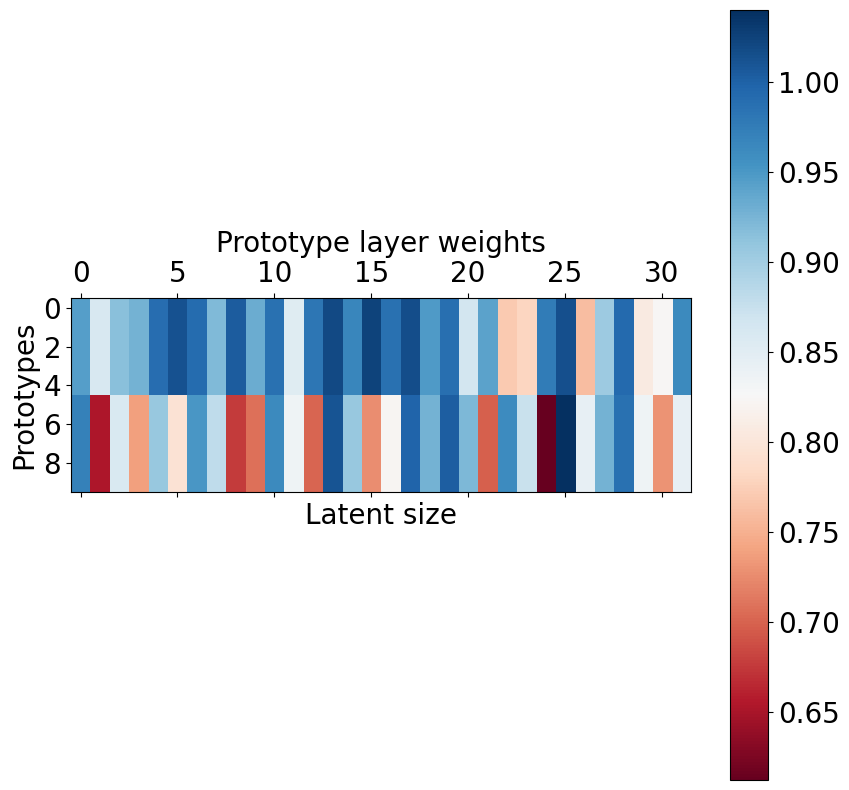

In [22]:
# Prototype layer weights
FONT_SIZE = 20
protos = model.prototype_layer.get_weights().data
protos = np.squeeze(protos.cpu().numpy())
print(f"Minimum value of prototype features in the latent space: {protos.min()}")
print(f"Maximum value of prototype features in the latent space: {protos.max()}")

fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
cax = ax.matshow(protos, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Latent size")
plt.ylabel("Prototypes")
plt.title("Prototype layer weights")
plt.savefig(checkpoint_path + "Prototype_layer_weights", dpi=600, bbox_inches="tight")

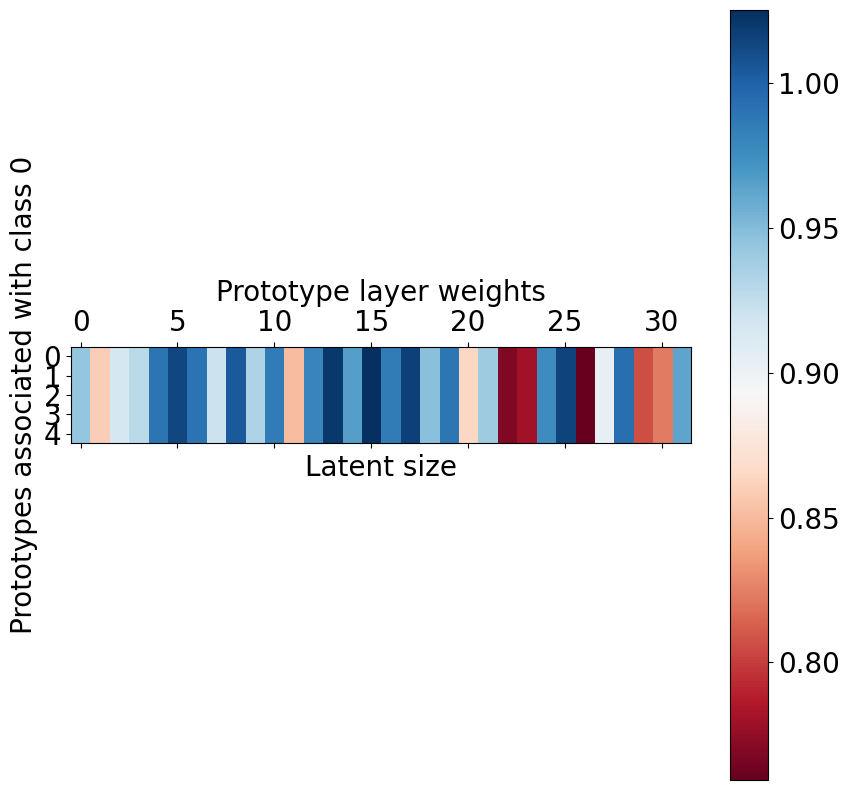

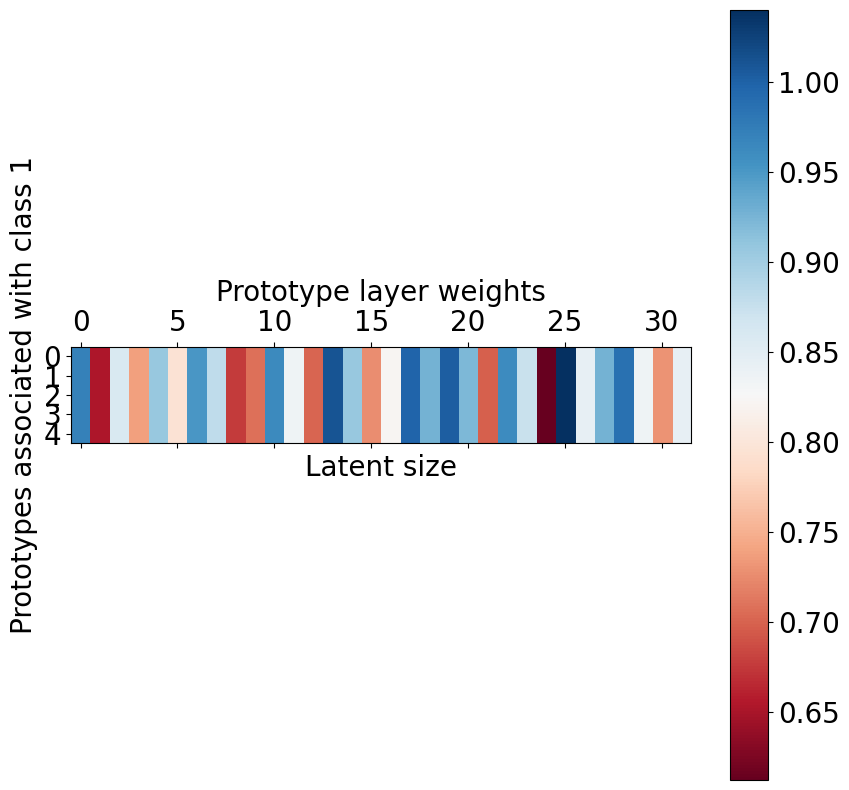

In [23]:
protos_0 = []
protos_1 = []
for i in range(protos.shape[0]):
    if int(matched_labels[i]) == 0:
        protos_0.append(protos[i])
    else:
        protos_1.append(protos[i])
protos_0 = np.stack(protos_0, axis=0)
protos_1 = np.stack(protos_1, axis=0)

print(f"Minimum value of prototype features in the latent space: {protos_0.min()}")
print(f"Maximum value of prototype features in the latent space: {protos_0.max()}")
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos_0, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Latent size")
plt.ylabel("Prototypes associated with class 0")
plt.title("Prototype layer weights")
plt.savefig(checkpoint_path + "Prototype_class_0_layer_weights", dpi=600)

print(f"Minimum value of prototype features in the latent space: {protos_1.min()}")
print(f"Maximum value of prototype features in the latent space: {protos_1.max()}")
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos_1, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Latent size")
plt.ylabel("Prototypes associated with class 1")
plt.title("Prototype layer weights")
plt.savefig(checkpoint_path + "Prototype_class_1_layer_weights", dpi=600)

clear_output(wait=True)

#### Feature analysis

In [25]:
# Calculate hand-crafted features for prototypes
class_labels = [0, 1]
class_names = ["healthy", "dyslexia"]

protoNums, protoLabels = [], []
active_read_times, fixation_intersection_coeffs, saccade_variabilities, fixation_intersection_variabilities = [], [], [], []
fixation_fractal_dimensions, fixation_counts, fixation_total_durs = [], [], []
fixation_freqs, fixation_avg_durs, saccade_counts, saccade_total_durs = [], [], [], []
saccade_freqs, saccade_avg_durs, total_read_times = [], [], []

for i in range(unique_matched_protos.shape[0]):
    prototype = unique_matched_protos[i,:,:]
    x = prototype[0,:]
    y = prototype[1,:]
    readTime = len(x) / Fs
    t = np.linspace(0, readTime*1000, len(x), 1/Fs*1000)  # Time in milliseconds
    
    print(f"Prototype {ids[i]+1} associated with class {class_names[int(unique_matched_labels[i])]}:")
    success, active_read_time, fixation_intersection_coeff, saccade_variability, fixation_intersection_variability, fixation_fractal_dimension, fixation_count, fixation_total_dur, fixation_freq, fixation_avg_dur, saccade_count, saccade_total_dur, saccade_freq, saccade_avg_dur, total_read_time = feature_extraction(t, x, y, Fs, verbose=True)

    protoNums.append(ids[i]+1)
    protoLabels.append(int(unique_matched_labels[i]))
    active_read_times.append(active_read_time)
    fixation_intersection_coeffs.append(fixation_intersection_coeff)
    saccade_variabilities.append(saccade_variability)
    fixation_intersection_variabilities.append(fixation_intersection_variability)
    fixation_fractal_dimensions.append(fixation_fractal_dimension)
    fixation_counts.append(fixation_count)
    fixation_total_durs.append(fixation_total_dur)
    fixation_freqs.append(fixation_freq)
    fixation_avg_durs.append(fixation_avg_dur)
    saccade_counts.append(saccade_count)
    saccade_total_durs.append(saccade_total_dur)
    saccade_freqs.append(saccade_freq)
    saccade_avg_durs.append(saccade_avg_dur)
    total_read_times.append(total_read_time)

Prototype 1 associated with class healthy:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Active reading time: 5.8 s
Fixation intersection coefficient: 0.55
Saccade variability: 136.6  msec
Fixation intersection variability: 1.36
Fixation fractal dimension: 1.28
Fixation count: 20
Fixation total duration: 4595.3 ms
Fixation frequenc:y 3.3 Hz
Fixation average duration: 241.9 ms
Saccade count: 18
Saccade total duration: 1163.9 ms
Saccade frequency: 3.0 Hz
Saccade average duration: 61.3 ms
Total reading time: 6.0 s

Prototype 6 associated with class dyslexia:


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Active reading time: 5.2 s
Fixation intersection coefficient: 0.69
Saccade variability: 158.6  msec
Fixation intersection variability: 1.21
Fixation fractal dimension: 1.39
Fixation count: 16
Fixation total duration: 4354.5 ms
Fixation frequenc:y 2.7 Hz
Fixation average duration: 290.3 ms
Saccade count: 11
Saccade total duration: 842.8 ms
Saccade frequency: 1.8 Hz
Saccade average duration: 56.2 ms
Total reading time: 6.0 s



In [28]:
print("CLASS 0 PROTOTYPES: FEATURES")
print(f"Percentage of prototypes that belong to class 0: {(1 - sum(protoLabels)/len(protoLabels)) * 100}%")
print(f"Prototypes that belong to class 0: {[protoNums[i] for i in range(len(protoLabels)) if protoLabels[i]==0]}")

active_read_times_0 = [active_read_times[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_intersection_coeffs_0 = [fixation_intersection_coeffs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
saccade_variabilities_0 = [saccade_variabilities[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_intersection_variabilities_0 = [fixation_intersection_variabilities[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_fractal_dimensions_0 = [fixation_fractal_dimensions[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_counts_0 = [fixation_counts[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_total_durs_0 = [fixation_total_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_freqs_0 = [fixation_freqs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
fixation_avg_durs_0 = [fixation_avg_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
saccade_counts_0 = [saccade_counts[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
saccade_total_durs_0 = [saccade_total_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
saccade_freqs_0 = [saccade_freqs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
saccade_avg_durs_0 = [saccade_avg_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==0]
total_read_times_0 = [total_read_times[i] for i in range(len(protoLabels)) if protoLabels[i]==0]

print(f"Average active reading time [s]: {np.nanmean(active_read_times_0)} (std: {np.nanstd(active_read_times_0)})")
print(f"Average fixation intersection coefficient: {np.nanmean(fixation_intersection_coeffs_0)} (std: {np.nanstd(fixation_intersection_coeffs_0)})")
print(f"Average saccade variability [ms]: {np.nanmean(saccade_variabilities_0)} (std: {np.nanstd(saccade_variabilities_0)})")
print(f"Average fixation intersection variability: {np.nanmean(fixation_intersection_variabilities_0)} (std: {np.nanstd(fixation_intersection_variabilities_0)})")
print(f"Average fixation fractal dimension: {np.nanmean(fixation_fractal_dimensions_0)} (std: {np.nanstd(fixation_fractal_dimensions_0)})")
print(f"Average fixation count: {np.nanmean(fixation_counts_0)} (std: {np.nanstd(fixation_counts_0)})")
print(f"Average fixation total duration [ms]: {np.nanmean(fixation_total_durs_0)} (std: {np.nanstd(fixation_total_durs_0)})")
print(f"Fixation frequency [Hz]: {np.nanmean(fixation_freqs_0)} (std: {np.nanstd(fixation_freqs_0)})")
print(f"Average fixation average duration [ms]: {np.nanmean(fixation_avg_durs_0)} (std: {np.nanstd(fixation_avg_durs_0)})")
print(f"Average saccade count: {np.nanmean(saccade_counts_0)} (std: {np.nanstd(saccade_counts_0)})")
print(f"Average saccade total duration [ms]: {np.nanmean(saccade_total_durs_0)} (std: {np.nanstd(saccade_total_durs_0)})")
print(f"Average saccade frequency [Hz]: {np.nanmean(saccade_freqs_0)} (std: {np.nanstd(saccade_freqs_0)})")
print(f"Average saccade average duration [ms]: {np.nanmean(saccade_avg_durs_0)} (std: {np.nanstd(saccade_avg_durs_0)})")
print(f"Average total reading time [s]: {np.nanmean(total_read_times_0)} (std: {np.nanstd(total_read_times_0)})")

CLASS 0 PROTOTYPES: FEATURES
Percentage of prototypes that belong to class 0: 50.0%
Prototypes that belong to class 0: [1]
Average active reading time [s]: 5.759197324414717 (std: 0.0)
Average fixation intersection coefficient: 0.55 (std: 0.0)
Average saccade variability [ms]: 136.6023204691706 (std: 0.0)
Average fixation intersection variability: 1.359227721906819 (std: 0.0)
Average fixation fractal dimension: 1.2790773782767164 (std: 0.0)
Average fixation count: 20.0 (std: 0.0)
Average fixation total duration [ms]: 4595.31772575251 (std: 0.0)
Fixation frequency [Hz]: 3.3333333333333335 (std: 0.0)
Average fixation average duration [ms]: 241.85882767118474 (std: 0.0)
Average saccade count: 18.0 (std: 0.0)
Average saccade total duration [ms]: 1163.879598662206 (std: 0.0)
Average saccade frequency [Hz]: 3.0 (std: 0.0)
Average saccade average duration [ms]: 61.25682098222137 (std: 0.0)
Average total reading time [s]: 6.0 (std: 0.0)


In [29]:
print("CLASS 1 PROTOTYPES: FEATURES")
print(f"Percentage of prototypes that belong to class 1: {(1 - sum(protoLabels)/len(protoLabels)) * 100}%")
print(f"Prototypes that belong to class 1: {[protoNums[i] for i in range(len(protoLabels)) if protoLabels[i]==1]}")

active_read_times_1 = [active_read_times[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_intersection_coeffs_1 = [fixation_intersection_coeffs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
saccade_variabilities_1 = [saccade_variabilities[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_intersection_variabilities_1 = [fixation_intersection_variabilities[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_fractal_dimensions_1 = [fixation_fractal_dimensions[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_counts_1 = [fixation_counts[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_total_durs_1 = [fixation_total_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_freqs_1 = [fixation_freqs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
fixation_avg_durs_1 = [fixation_avg_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
saccade_counts_1 = [saccade_counts[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
saccade_total_durs_1 = [saccade_total_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
saccade_freqs_1 = [saccade_freqs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
saccade_avg_durs_1 = [saccade_avg_durs[i] for i in range(len(protoLabels)) if protoLabels[i]==1]
total_read_times_1 = [total_read_times[i] for i in range(len(protoLabels)) if protoLabels[i]==1]

print(f"Average active reading time [s]: {np.nanmean(active_read_times_1)} (std: {np.nanstd(active_read_times_1)})")
print(f"Average fixation intersection coefficient: {np.nanmean(fixation_intersection_coeffs_1)} (std: {np.nanstd(fixation_intersection_coeffs_1)})")
print(f"Average saccade variability [ms]: {np.nanmean(saccade_variabilities_1)} (std: {np.nanstd(saccade_variabilities_1)})")
print(f"Average fixation intersection variability: {np.nanmean(fixation_intersection_variabilities_1)} (std: {np.nanstd(fixation_intersection_variabilities_1)})")
print(f"Average fixation fractal dimension: {np.nanmean(fixation_fractal_dimensions_1)} (std: {np.nanstd(fixation_fractal_dimensions_1)})")
print(f"Average fixation count: {np.nanmean(fixation_counts_1)} (std: {np.nanstd(fixation_counts_1)})")
print(f"Average fixation total duration [ms]: {np.nanmean(fixation_total_durs_1)} (std: {np.nanstd(fixation_total_durs_1)})")
print(f"Fixation frequency [Hz]: {np.nanmean(fixation_freqs_1)} (std: {np.nanstd(fixation_freqs_1)})")
print(f"Average fixation average duration [ms]: {np.nanmean(fixation_avg_durs_1)} (std: {np.nanstd(fixation_avg_durs_1)})")
print(f"Average saccade count: {np.nanmean(saccade_counts_1)} (std: {np.nanstd(saccade_counts_1)})")
print(f"Average saccade total duration [ms]: {np.nanmean(saccade_total_durs_1)} (std: {np.nanstd(saccade_total_durs_1)})")
print(f"Average saccade frequency [Hz]: {np.nanmean(saccade_freqs_1)} (std: {np.nanstd(saccade_freqs_1)})")
print(f"Average saccade average duration [ms]: {np.nanmean(saccade_avg_durs_1)} (std: {np.nanstd(saccade_avg_durs_1)})")
print(f"Average total reading time [s]: {np.nanmean(total_read_times_1)} (std: {np.nanstd(total_read_times_1)})")

CLASS 1 PROTOTYPES: FEATURES
Percentage of prototypes that belong to class 1: 50.0%
Prototypes that belong to class 1: [6]
Average active reading time [s]: 5.197324414715719 (std: 0.0)
Average fixation intersection coefficient: 0.6875 (std: 0.0)
Average saccade variability [ms]: 158.5633507954426 (std: 0.0)
Average fixation intersection variability: 1.2103072956898178 (std: 0.0)
Average fixation fractal dimension: 1.3864830387233895 (std: 0.0)
Average fixation count: 16.0 (std: 0.0)
Average fixation total duration [ms]: 4354.515050167224 (std: 0.0)
Fixation frequency [Hz]: 2.6666666666666665 (std: 0.0)
Average fixation average duration [ms]: 290.3010033444816 (std: 0.0)
Average saccade count: 11.0 (std: 0.0)
Average saccade total duration [ms]: 842.8093645484946 (std: 0.0)
Average saccade frequency [Hz]: 1.8333333333333333 (std: 0.0)
Average saccade average duration [ms]: 56.18729096989964 (std: 0.0)
Average total reading time [s]: 6.0 (std: 0.0)


## Evaluation on the validation set

#### Evaluate the model on validation data

In [30]:
data_loader = validLoader

inputs, info, labels = zip(*[batch for batch in data_loader])
inputs = torch.cat(inputs, dim=0).to(train_params.device)
labels = torch.cat(labels, dim=0).to(train_params.device)

In [31]:
# Get predictions of all validation sequences
model.eval()
with torch.no_grad():
    if 'proto' in model_architecture:
        logits, _ = model.forward(inputs, labels)
    else:
        logits = model.forward(inputs, labels)
    predictions = logits
if model_params.criterion == 'BCE_with_logits':
    probabilities = nn.functional.sigmoid(predictions)
elif model_params.criterion == 'CE':
    probabilities = nn.functional.softmax(predictions, dim=1)
if model_params.criterion == 'BCE':
    predictions = (predictions[:,0] > 0.5) * 1.0
elif model_params.criterion == 'BCE_with_logits':
    predictions = (predictions[:,0] > 0.0) * 1.0
elif model_params.criterion == 'CE':
    predictions = torch.argmax(predictions, dim=-1)
targets = labels.squeeze(-1)
matches = (torch.eq(predictions, targets) * 1.0).detach().cpu().numpy().astype(int)

In [32]:
y_true = targets.detach().cpu().numpy().astype(int)
y_pred = predictions.detach().cpu().numpy().astype(int)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

if model_params.criterion == 'BCE_with_logits':
    y_score = probabilities.detach().cpu().numpy()
elif model_params.criterion == 'CE':
    y_score = probabilities.detach().cpu().numpy()[:,1]

acc = sklearn.metrics.accuracy_score(y_true, y_pred)
brier = sklearn.metrics.brier_score_loss(y_true, y_score)
auc = sklearn.metrics.roc_auc_score(y_true, y_score)
balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
f1 = sklearn.metrics.f1_score(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred)
recall = sklearn.metrics.recall_score(y_true, y_pred)

In [33]:
print(f"Validation accuracy: {acc}")
print(f"Balanced validation accuracy: {balanced_acc}")
print(f"Validation AUC: {auc}")
print(f"Validation precision: {precision}")
print(f"Validation recall: {recall}")
print("Validation confusion matrix:")
print(confusion_matrix)

Validation accuracy: 0.9583333333333334
Balanced validation accuracy: 0.9583333333333333
Validation AUC: 1.0
Validation precision: 0.9230769230769231
Validation recall: 1.0
Validation confusion matrix:
[[11  1]
 [ 0 12]]


In [34]:
# Get encodings of all validation sequences
model.eval()
with torch.no_grad():
    encoded_data = model.encoder.forward(inputs)
    latent = encoded_data['features']  # [batch_size, time_steps, embedding_size]
    if model_params.feature_aggregation == 'pooling':
        latent = torch.mean(latent, dim=1)
    else:
        latent = torch.flatten(latent, start_dim=1)
    latent = torch.unsqueeze(latent, dim=-2)    

#### Find closest prototypes to validation data

In [35]:
# For each validation example find the closest prototype
protos = model.prototype_layer.get_weights()
d2 = torch.norm(latent - protos, p=2, dim=-1)

In [36]:
distances, idxs = torch.min(d2, dim=-1)
distances = distances.detach().cpu().numpy()  # for each validation example calculate the distance to the found closest prototype
idxs = idxs.detach().cpu().numpy()  # indices of prototypes associated with each valudation example

In [37]:
def n_min(a, N=3):
    s = sorted(enumerate(a), key=lambda x:x[1])[:N]
    # seperate values from indexes using zip
    z_idx, z_value = map(list, zip(*s))
    # yield each tuple of (values,indexes)
    return z_value, z_idx

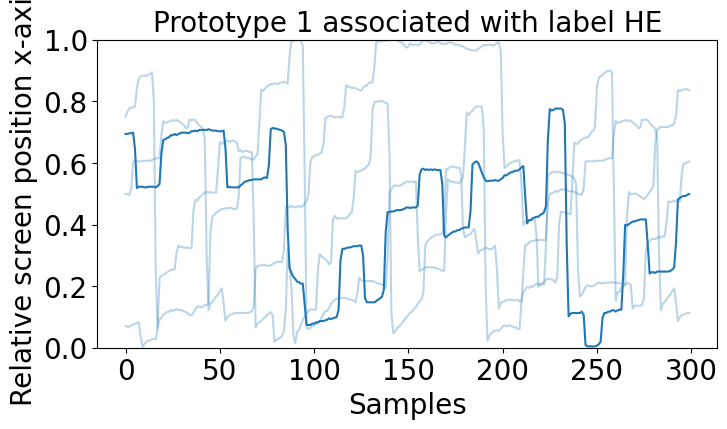

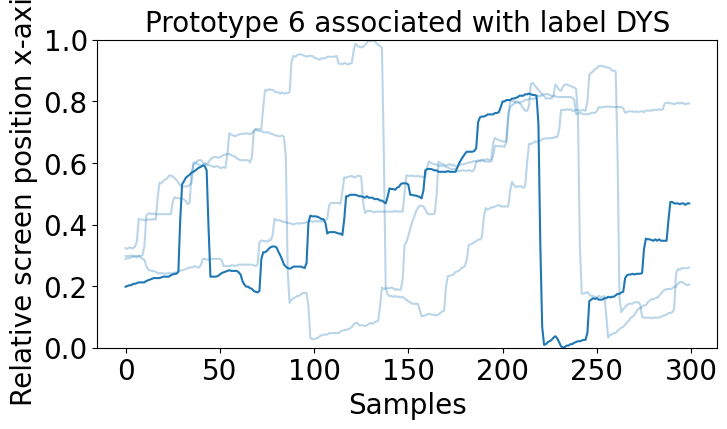

In [52]:
# Plot prototypes with their three most similar validation examples - x axis
class_names = ["HE", "DYS"]
for proto_id in ids:
    match_ids = np.where(idxs == proto_id)[0]
    prototype = unique_matched_protos[unique_idxs.index(protos_idxs[proto_id])]
    
    distances_valid = distances[match_ids]  # distances of validation examples whose closest prototype is the current one
    if distances_valid.any():
        _, valid_ids = n_min(distances_valid, 3)
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(prototype.shape[-1]), prototype[0,:], c='#1f77b4')
        for valid_id in valid_ids:
            input_valid = inputs[match_ids[valid_id],:,:].detach().cpu().numpy()
            if targets[valid_id] == 0:
                plt.plot(np.arange(input_valid.shape[-1]), input_valid[0,:], c='#1f77b4', alpha=0.3)
                plt.title(f"Prototype {proto_id+1} associated with label {class_names[int(matched_labels[proto_id])]}")
                plt.ylim([0, 1])
                plt.xlabel("Samples")
                plt.ylabel("Relative screen position x-axis")
        plt.savefig(checkpoint_path + "Prototype_" + str(proto_id+1) + "_closest_val_examples_x_axis.png", dpi=600)
        plt.show()
        plt.close()

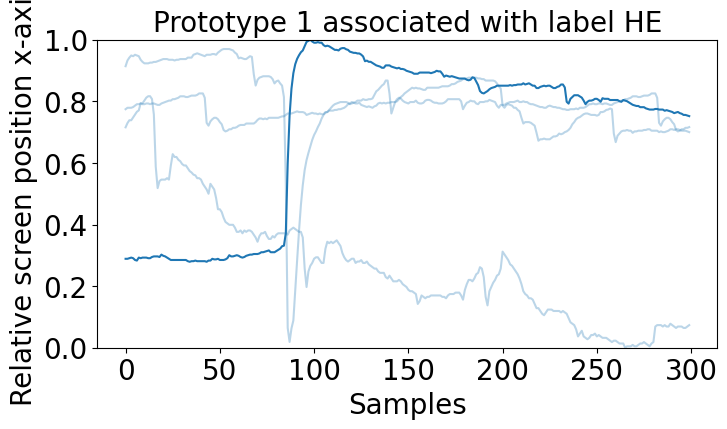

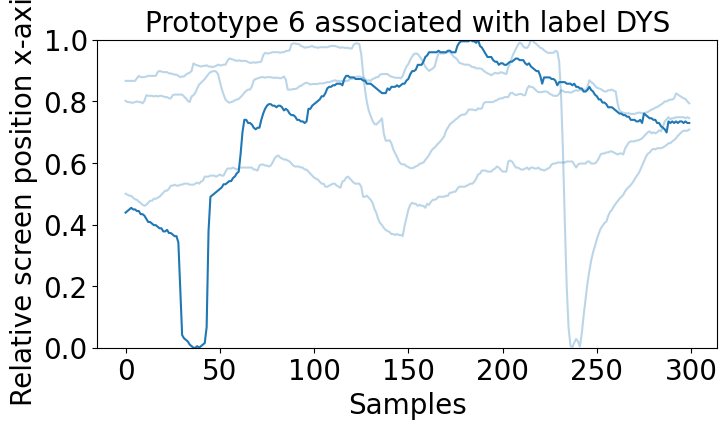

In [53]:
# Plot prototypes with their three most similar validation examples - y axis
class_names = ["HE", "DYS"]
for proto_id in ids:
    match_ids = np.where(idxs == proto_id)[0]
    prototype = unique_matched_protos[unique_idxs.index(protos_idxs[proto_id])]
    
    distances_valid = distances[match_ids]  # distances of validation examples whose closest prototype is the current one
    if distances_valid.any():
        _, valid_ids = n_min(distances_valid, 3)
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(prototype.shape[-1]), prototype[1,:], c='#1f77b4')
        for valid_id in valid_ids:
            input_valid = inputs[match_ids[valid_id],:,:].detach().cpu().numpy()
            if targets[valid_id] == 0:
                plt.plot(np.arange(input_valid.shape[-1]), input_valid[1,:], c='#1f77b4', alpha=0.3)
                plt.title(f"Prototype {proto_id+1} associated with label {class_names[int(matched_labels[proto_id])]}")
                plt.ylim([0, 1])
                plt.xlabel("Samples")
                plt.ylabel("Relative screen position x-axis")
        plt.savefig(checkpoint_path + "Prototype_" + str(proto_id+1) + "_closest_val_examples_y_axis.png", dpi=600)
        plt.show()
        plt.close()

#### Investigating the similarities

In [51]:
# Comparison with unique protos
# unique_protos_latent = protos[:, ids, :]

print("Distances from unique prototypes:")
unique_d2 = d2[:, ids]
print(unique_d2)

print("\nUnique similarity scores:")
unique_similarity_scores = torch.exp(-unique_d2)
print(unique_similarity_scores)

Distances from unique prototypes:
tensor([[0.6737, 1.4433],
        [0.4284, 1.1402],
        [0.4253, 0.6452],
        [0.2813, 0.8581],
        [0.2770, 0.7597],
        [0.4822, 0.5558],
        [0.4782, 0.5067],
        [0.6237, 0.3729],
        [0.3742, 1.1095],
        [0.3245, 1.0769],
        [0.9169, 1.7460],
        [0.6996, 1.5287],
        [1.1112, 0.3500],
        [1.0299, 0.2522],
        [1.0477, 0.3448],
        [1.1595, 0.3982],
        [0.9193, 0.1740],
        [1.2030, 0.4804],
        [1.1279, 0.3994],
        [1.0183, 0.3066],
        [1.0302, 0.3557],
        [1.0922, 0.3640],
        [1.1257, 0.3423],
        [1.3572, 0.5682]], device='cuda:0', grad_fn=<IndexBackward0>)

Unique similarity scores:
tensor([[0.5098, 0.2362],
        [0.6516, 0.3197],
        [0.6536, 0.5245],
        [0.7548, 0.4239],
        [0.7581, 0.4678],
        [0.6174, 0.5736],
        [0.6199, 0.6025],
        [0.5360, 0.6887],
        [0.6878, 0.3297],
        [0.7229, 0.3407],
        [0.

In [54]:
# Get the three closest prototypes to the input validation example
dist_vals, dist_ids = n_min(unique_d2[0,:].detach().cpu().numpy(), 3)

In [55]:
print(f"Prototypes closest to the selected validation example: {ids[dist_ids] + 1}")

Prototypes closest to the selected validation example: [1 6]


In [56]:
decoder_weights = model.decoder.last_linear.weight.detach().cpu().numpy()

In [58]:
print("Decoder weights:")
for col in range(np.shape(decoder_weights)[1]):
    print(f"Prototype {col + 1} of class {class_names[matched_labels[col]]}:", end = "\t")
    print("{:.4f}".format(decoder_weights[0][col]), end = " ")
    print("{:.4f}".format(decoder_weights[1][col]), end = " ")
    print()
    if col in ids:  # If the prototype is unique
        prototype = unique_matched_protos[list(ids).index(col)]
        x = prototype[0,:]
        y = prototype[1,:]
        readTime = len(x) / Fs
        t = np.linspace(0, readTime*1000, len(x), 1/Fs*1000)  # Time in milliseconds
        success, active_read_time, fixation_intersection_coeff, saccade_variability, fixation_intersection_variability, fixation_fractal_dimension, fixation_count, fixation_total_dur, fixation_freq, fixation_avg_dur, saccade_count, saccade_total_dur, saccade_freq, saccade_avg_dur, total_read_time = feature_extraction(t, x, y, Fs, verbose=True)
    else:
        print()

Decoder weights:
Prototype 1 of class HE:	1.2753 -0.8476 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Active reading time: 5.8 s
Fixation intersection coefficient: 0.55
Saccade variability: 136.6  msec
Fixation intersection variability: 1.36
Fixation fractal dimension: 1.28
Fixation count: 20
Fixation total duration: 4595.3 ms
Fixation frequenc:y 3.3 Hz
Fixation average duration: 241.9 ms
Saccade count: 18
Saccade total duration: 1163.9 ms
Saccade frequency: 3.0 Hz
Saccade average duration: 61.3 ms
Total reading time: 6.0 s

Prototype 2 of class HE:	1.2752 -0.8494 

Prototype 3 of class HE:	1.2750 -0.8493 

Prototype 4 of class HE:	1.2751 -0.8493 

Prototype 5 of class HE:	1.2751 -0.8493 

Prototype 6 of class DYS:	-0.7985 1.2883 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Active reading time: 5.2 s
Fixation intersection coefficient: 0.69
Saccade variability: 158.6  msec
Fixation intersection variability: 1.21
Fixation fractal dimension: 1.39
Fixation count: 16
Fixation total duration: 4354.5 ms
Fixation frequenc:y 2.7 Hz
Fixation average duration: 290.3 ms
Saccade count: 11
Saccade total duration: 842.8 ms
Saccade frequency: 1.8 Hz
Saccade average duration: 56.2 ms
Total reading time: 6.0 s

Prototype 7 of class DYS:	-0.7986 1.2883 

Prototype 8 of class DYS:	-0.7986 1.2884 

Prototype 9 of class DYS:	-0.7981 1.2879 

Prototype 10 of class DYS:	-0.7984 1.2881 



In [59]:
sorted_proto_ids = np.argsort(decoder_weights[0,:], axis=0)
sorted_decoder_weights = np.take_along_axis(decoder_weights, np.tile(sorted_proto_ids, (2, 1)), axis=1)
sorted_decoder_weights = sorted_decoder_weights[:, ::-1]
sorted_matched_labels = np.take_along_axis(matched_labels, sorted_proto_ids, axis=0)
sorted_matched_labels = sorted_matched_labels[::-1]
sorted_proto_ids = sorted_proto_ids[::-1]

print("Sorted decoder weights:")
for col in range(np.shape(sorted_decoder_weights)[1]):
    print(f"Prototype {sorted_proto_ids[col] + 1} of class {class_names[sorted_matched_labels[col]]}:", end = "\t")
    print("{:.4f}".format(sorted_decoder_weights[0][col]), end = " ")
    print("{:.4f}".format(sorted_decoder_weights[1][col]), end = " ")
    print()

Sorted decoder weights:
Prototype 1 of class HE:	1.2753 -0.8476 
Prototype 2 of class HE:	1.2752 -0.8494 
Prototype 5 of class HE:	1.2751 -0.8493 
Prototype 4 of class HE:	1.2751 -0.8493 
Prototype 3 of class HE:	1.2750 -0.8493 
Prototype 9 of class DYS:	-0.7981 1.2879 
Prototype 10 of class DYS:	-0.7984 1.2881 
Prototype 6 of class DYS:	-0.7985 1.2883 
Prototype 7 of class DYS:	-0.7986 1.2883 
Prototype 8 of class DYS:	-0.7986 1.2884 


In [60]:
print("Class connections to closest prototypes:")
print(decoder_weights[:, ids[dist_ids]])

Class connections to closest prototypes:
[[ 1.2753029  -0.79851425]
 [-0.84761524  1.2883104 ]]


#### Time domain analysis - similarity metrics

In [61]:
# Time-series similarity measures
def calc_euclidean(actual, predic):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(actual, predic):
    return np.mean(np.abs(np.divide((actual - predic), actual, out=np.zeros_like(actual), where=actual!=0)))

def calc_correlation(actual, predic):
    a_diff = actual - np.mean(actual)
    p_diff = predic - np.mean(predic)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator

# DTW - doesn't work well for value offsets (two time series should be standardized)

# CBD & SAX

In [62]:
# Comparison of one validation example with one prototype
valid_x = input_valid[0,:]
valid_y = input_valid[1,:]

for dist_id in dist_ids:
    prototype = unique_matched_protos[dist_id]
    proto_x = prototype[0,:]
    proto_y = prototype[1,:]
    euclidean_dist = calc_euclidean(proto_x, valid_x)
    mape = calc_mape(proto_x, valid_x)
    corr = calc_correlation(proto_x, valid_x)
    print(f"Comparison of the validation example with the prototype {ids[dist_id]+1}")
    print(f"Euclidean distance = {euclidean_dist}")
    print(f"MAPE = {mape}")
    print(f"Pearson's correlation = {corr}")

Comparison of the validation example with the prototype 1
Euclidean distance = 6.22562837600708
MAPE = 5.1255974769592285
Pearson's correlation = -0.34710025787353516
Comparison of the validation example with the prototype 6
Euclidean distance = 5.607324123382568
MAPE = 5.702208042144775
Pearson's correlation = 0.07647647708654404


#### Validation set analysis

In [64]:
unique_id = 0
for i in range(len(protos_idxs)):
    match_ids = np.where(idxs == i)[0]
    prototype = unique_matched_protos[unique_idxs.index(protos_idxs[i])]
    class_label = int(unique_matched_labels[unique_idxs.index(protos_idxs[i])])
    
    active_read_times, fixation_intersection_coeffs, saccade_variabilities, fixation_intersection_variabilities = [], [], [], []
    fixation_fractal_dimensions, fixation_counts, fixation_total_durs = [], [], []
    fixation_freqs, fixation_avg_durs, saccade_counts, saccade_total_durs = [], [], [], []
    saccade_freqs, saccade_avg_durs, total_read_times = [], [], []
    
    for j in range(len(match_ids)):
        if distances[match_ids[j]] < 0.5:  # Distance of 0.5 is manually set
            input_valid = inputs[match_ids[j],:,:].detach().cpu().numpy()
            label_valid = int(labels[match_ids[j]].detach().cpu().numpy())
            x = input_valid[0,:]
            y = input_valid[1,:]
            readTime = len(x) / Fs
            t = np.linspace(0, readTime*1000, len(x), 1/Fs*1000)  # Time in milliseconds

            success, active_read_time, fixation_intersection_coeff, saccade_variability, fixation_intersection_variability, fixation_fractal_dimension, fixation_count, fixation_total_dur, fixation_freq, fixation_avg_dur, saccade_count, saccade_total_dur, saccade_freq, saccade_avg_dur, total_read_time = feature_extraction(t, x, y, Fs, verbose=False)
            active_read_times.append(active_read_time)
            fixation_intersection_coeffs.append(fixation_intersection_coeff)
            saccade_variabilities.append(saccade_variability)
            fixation_intersection_variabilities.append(fixation_intersection_variability)
            fixation_fractal_dimensions.append(fixation_fractal_dimension)
            fixation_counts.append(fixation_count)
            fixation_total_durs.append(fixation_total_dur)
            fixation_freqs.append(fixation_freq)
            fixation_avg_durs.append(fixation_avg_dur)
            saccade_counts.append(saccade_count)
            saccade_total_durs.append(saccade_total_dur)
            saccade_freqs.append(saccade_freq)
            saccade_avg_durs.append(saccade_avg_dur)
            total_read_times.append(total_read_time)
    
    if active_read_times:
        print(f'Prototype {ids[unique_id]+1} matching validation examples features:')
        print(f"Average active reading time [s]: {np.nanmean(active_read_times)} (std: {np.nanstd(active_read_times)})")
        print(f"Average fixation intersection coefficient: {np.nanmean(fixation_intersection_coeffs)} (std: {np.nanstd(fixation_intersection_coeffs)})")
        print(f"Average saccade variability [ms]: {np.nanmean(saccade_variabilities)} (std: {np.nanstd(saccade_variabilities)})")
        print(f"Average fixation intersection variability: {np.nanmean(fixation_intersection_variabilities)} (std: {np.nanstd(fixation_intersection_variabilities)})")
        print(f"Average fixation fractal dimension: {np.nanmean(fixation_fractal_dimensions)} (std: {np.nanstd(fixation_fractal_dimensions)})")
        print(f"Average fixation count: {np.nanmean(fixation_counts)} (std: {np.nanstd(fixation_counts)})")
        print(f"Average fixation total duration [ms]: {np.nanmean(fixation_total_durs)} (std: {np.nanstd(fixation_total_durs)})")
        print(f"Fixation frequency [Hz]: {np.nanmean(fixation_freqs)} (std: {np.nanstd(fixation_freqs)})")
        print(f"Average fixation average duration [ms]: {np.nanmean(fixation_avg_durs)} (std: {np.nanstd(fixation_avg_durs)})")
        print(f"Average saccade count: {np.nanmean(saccade_counts)} (std: {np.nanstd(saccade_counts)})")
        print(f"Average saccade total duration [ms]: {np.nanmean(saccade_total_durs)} (std: {np.nanstd(saccade_total_durs)})")
        print(f"Average saccade frequency [Hz]: {np.nanmean(saccade_freqs)} (std: {np.nanstd(saccade_freqs)})")
        print(f"Average saccade average duration [ms]: {np.nanmean(saccade_avg_durs)} (std: {np.nanstd(saccade_avg_durs)})")
        print(f"Average total reading time [s]: {np.nanmean(total_read_times)} (std: {np.nanstd(total_read_times)})")
        print()
        unique_id += 1

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Prototype 1 matching validation examples features:
Average active reading time [s]: 5.535953177257525 (std: 0.17157997399327113)
Average fixation intersection coefficient: 0.5153070613596928 (std: 0.2196230068647245)
Average saccade variability [ms]: 112.99722716461653 (std: 56.00788017959827)
Average fixation intersection variability: 1.1065526865446063 (std: 0.43038583283411674)
Average fixation fractal dimension: 1.3039173682701688 (std: 0.03769519931046505)
Average fixation count: 21.75 (std: 2.1065374432940898)
Average fixation total duration [ms]: 4281.772575250836 (std: 155.41721814039815)
Fixation frequency [Hz]: 3.625 (std: 0.3510895738823482)
Average fixation average duration [ms]: 208.76222291952072 (std: 25.07034827744461)
Average saccade count: 19.875 (std: 1.8328597873268975)
Average saccade total duration [ms]: 1254.1806020066888 (std: 160.84835660750528)
Average saccade frequency [Hz]: 3.3125 (std: 0.3054766312211496)
Average saccade average duration [ms]: 60.3644080027

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Prototype 6 matching validation examples features:
Average active reading time [s]: 5.2157190635451505 (std: 0.43853219801628507)
Average fixation intersection coefficient: 1.2070592601842602 (std: 0.8148707254882364)
Average saccade variability [ms]: 231.81818872448648 (std: 112.24655585931336)
Average fixation intersection variability: 2.0649593244592115 (std: 1.114982116044086)
Average fixation fractal dimension: 1.293306644450863 (std: 0.03416256074423009)
Average fixation count: 15.416666666666666 (std: 3.3778280332518738)
Average fixation total duration [ms]: 4449.832775919733 (std: 364.5446595484161)
Fixation frequency [Hz]: 2.5694444444444446 (std: 0.5629713388753123)
Average fixation average duration [ms]: 321.91312446587466 (std: 62.23424806526885)
Average saccade count: 12.916666666666666 (std: 3.6391009268163415)
Average saccade total duration [ms]: 765.886287625418 (std: 214.5426948490922)
Average saccade frequency [Hz]: 2.152777777777778 (std: 0.606516821136057)
Average s